# This is our final notebook aggregating our final results

In [5]:
from helpers import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier # pip install imblearn - scikit wrapper
from sklearn import ensemble, pipeline, model_selection, metrics, preprocessing, svm, tree, neighbors
from tqdm import tqdm
from tensorflow import keras
import tensorflow as tf

DATA_PATH = '../data/'
PKL_PATH = '../pickles/'
IMG_PATH = '../imgs/'

seed = 0
parallel_jobs = 10

data = load_data(DATA_PATH)

## Roc-Auc

### SVM:

In [11]:
# svm grid search for roc-auc curve all variables
X, y = data['muchlinski']
scoring='roc_auc'
svm_pkl = PKL_PATH + 'gs_rocauc_svm_all.pkl'

k_folds = 5
C = [0.0001, 0.001, 0.01, 0.05, 1, 2.5, 5]
c_weight = [{0:1, 1:2**i} for i in range(5)]
degree = np.arange(1,8)

# create two parameter sets otherwise grid search tries every degree
# even when the degree has no influence on non-poly kernels
parameter_non_poly = {'clf__kernel' : ('linear','rbf','sigmoid'),
                      'clf__C' :  C,
                      'clf__class_weight' : c_weight}
parameter_poly = {'clf__kernel' : ['poly'],
                  'clf__degree' : degree,
                  'clf__C' :  C,
                  'clf__class_weight' : c_weight}

param_grid = [parameter_non_poly, parameter_poly]

my_svm = svm.SVC(random_state=seed)
my_std = preprocessing.StandardScaler()

pipe = pipeline.Pipeline([('std',my_std), ('clf',my_svm)])

perform_gridsearch_cv(X, y, param_grid, pipe, k_folds, scoring, svm_pkl, parallel_jobs)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   26.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done 1500 out of 1500 | elapsed:  4.8min finished


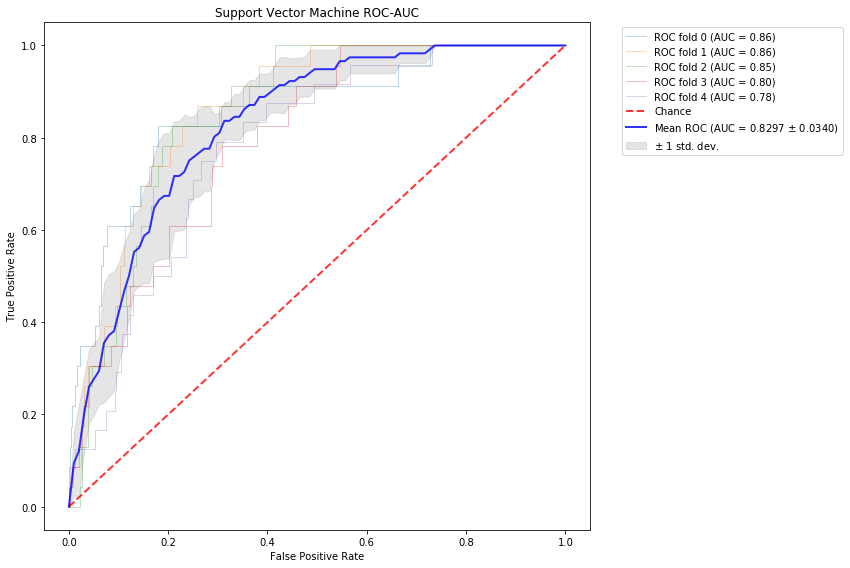

Parameters used:
 C                      0.001
class_weight    {0: 1, 1: 8}
kernel                   rbf
degree                     1
Name: 10, dtype: object


In [2]:
# load grid search result
svm_pkl = PKL_PATH + 'gs_rocauc_svm_all.pkl'
svm_gs_res = pd.read_pickle(svm_pkl)

X, y = data['muchlinski']

# retrieve best parameters
params = svm_gs_res.drop('roc_auc',axis=1).iloc[0]
params['degree'] = 1 if np.isnan(params['degree']) else params['degree']

my_svm = svm.SVC(random_state=seed)
my_std = preprocessing.StandardScaler()

# set best parameters
pipe = pipeline.Pipeline([('std',my_std), ('clf',my_svm)])
pipe['clf'].set_params(**params.to_dict())

# plot resulting roc plot
svm_res = roc_plt(X, y, pipe, "Support Vector Machine ROC-AUC", seed=seed, create_plot=True)
print(f"Parameters used:\n {params}")

### Boosted Decision Trees

In [66]:
# svm grid search for roc-auc curve all variables
X, y = data['muchlinski']
scoring='roc_auc'
bdt_pkl = PKL_PATH + 'gs_rocauc_bdt_all.pkl'

k_folds = 5
trees = np.arange(5,21) * 10
learning_rates = [0.1,0.5,1,1.5,2,5]
max_depth = np.arange(1,11)

parameters = {'clf__n_estimators' : trees,
              'clf__learning_rate' :  learning_rates,
              'clf__base_estimator__max_depth' : max_depth}

param_grid = [parameters]

my_bdt = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(), random_state=0)
my_std = preprocessing.StandardScaler()

pipe = pipeline.Pipeline([('std',my_std), ('clf',my_bdt)])
perform_gridsearch_cv(X, y, param_grid, pipe, k_folds, scoring, bdt_pkl, parallel_jobs)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   10.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  7.4min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 14.5min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 31.9min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 46.3min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 70.7min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 99.0min
[Parallel(n_jobs=10)]: Done 4800 out of 4800 | elapsed: 124.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('clf',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                                           random_state=0))]),
             n_jobs=10,
             param_grid=[{'clf__base_estimator__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                          'clf__learning_rate': [0.1, 0.5, 1, 1.5, 2, 5],
                          'clf__n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200])}],
             scoring='roc_auc', verbose=1)

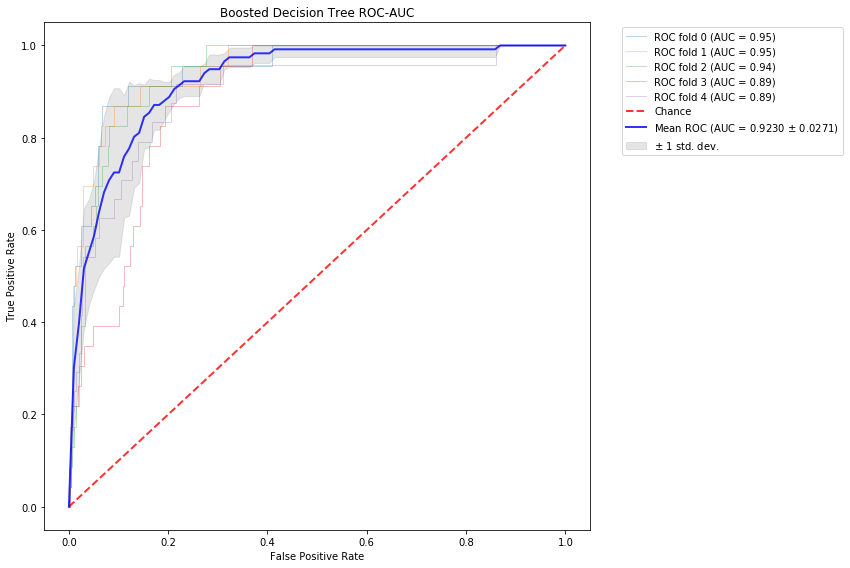

Parameters used:
 {'base_estimator__max_depth': 8.0, 'learning_rate': 1.0, 'n_estimators': 140}


In [2]:
# load grid search result
bdt_pkl = PKL_PATH + 'gs_rocauc_bdt_all.pkl'
bdt_gs_res = pd.read_pickle(bdt_pkl)

X, y = data['muchlinski']

# retrieve best parameters
params = bdt_gs_res.drop('roc_auc',axis=1).iloc[0].to_dict()
params['n_estimators'] = int(params['n_estimators'])

my_bdt = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(), random_state=0)
my_std = preprocessing.StandardScaler()

# set best parameters
pipe = pipeline.Pipeline([('std',my_std), ('clf',my_bdt)])
pipe['clf'].set_params(**params)

# plot resulting roc plot
bdt_res = roc_plt(X, y, pipe, "Boosted Decision Tree ROC-AUC", seed=seed, create_plot=True)
print(f"Parameters used:\n {params}")

### KNN

In [ ]:
# knn grid search for roc-auc curve all variables
X, y = data['muchlinski']
scoring='roc_auc'
knn_pkl = PKL_PATH + 'gs_rocauc_knn_all.pkl'

k_folds = 5
n_neighbors = np.arange(2,10)
weights = ['uniform','distance']
p = np.arange(1,5)

parameters = {'clf__n_neighbors' : n_neighbors,
              'clf__weights' :  weights,
              'clf__p' : p}

param_grid = [parameters]

my_knn = neighbors.KNeighborsClassifier()
my_std = preprocessing.StandardScaler()

pipe = pipeline.Pipeline([('std',my_std), ('clf',my_knn)])

perform_gridsearch_cv(X, y, param_grid, pipe, k_folds, scoring, knn_pkl, parallel_jobs)

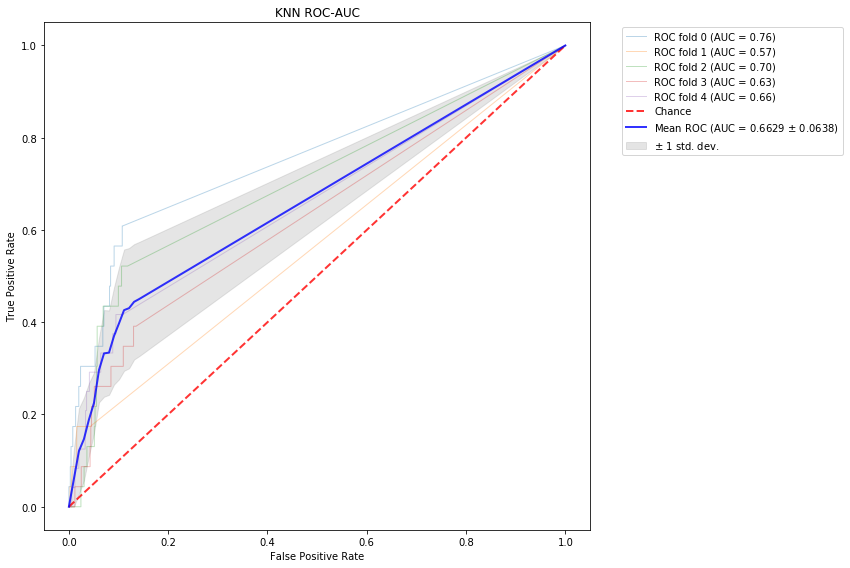

Parameters used:
 n_neighbors           9
p                     1
weights        distance
Name: 57, dtype: object


In [3]:
# load grid search result
knn_pkl = PKL_PATH + 'gs_rocauc_knn_all.pkl'
knn_gs_res = pd.read_pickle(PKL_PATH+'gs_rocauc_knn_all.pkl')

X, y = data['muchlinski']

# retrieve best parameters
params = knn_gs_res.drop('roc_auc',axis=1).iloc[0]

my_knn = neighbors.KNeighborsClassifier()
my_std = preprocessing.StandardScaler()

# set best parameters
pipe = pipeline.Pipeline([('std',my_std), ('clf',my_knn)])
pipe['clf'].set_params(**params.to_dict())

# plot resulting roc plot
knn_res = roc_plt(X, y, pipe, "KNN ROC-AUC", seed=seed, create_plot=True)
print(f"Parameters used:\n {params}")

### RF 

In [3]:
# svm grid search for roc-auc curve all variables
X, y = data['muchlinski']
scoring='roc_auc'
brf_pkl = PKL_PATH + 'gs_rocauc_brf_all.pkl'

k_folds = 5
trees = [500,750,1000,1250,1500]
downsample_proportion=[1/2, 1/4, 1/8, 1/16]
max_depth = np.arange(4,9)

parameters = {'clf__n_estimators' : trees,
              'clf__sampling_strategy' :  downsample_proportion,
              'clf__max_depth' : max_depth}

param_grid = [parameters]

my_brf = BalancedRandomForestClassifier()
my_std = preprocessing.StandardScaler()

pipe = pipeline.Pipeline([('std',my_std), ('clf',my_brf)])

perform_gridsearch_cv(X, y, param_grid, pipe, k_folds, scoring, brf_pkl, parallel_jobs)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   16.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  6.3min
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:  7.6min finished


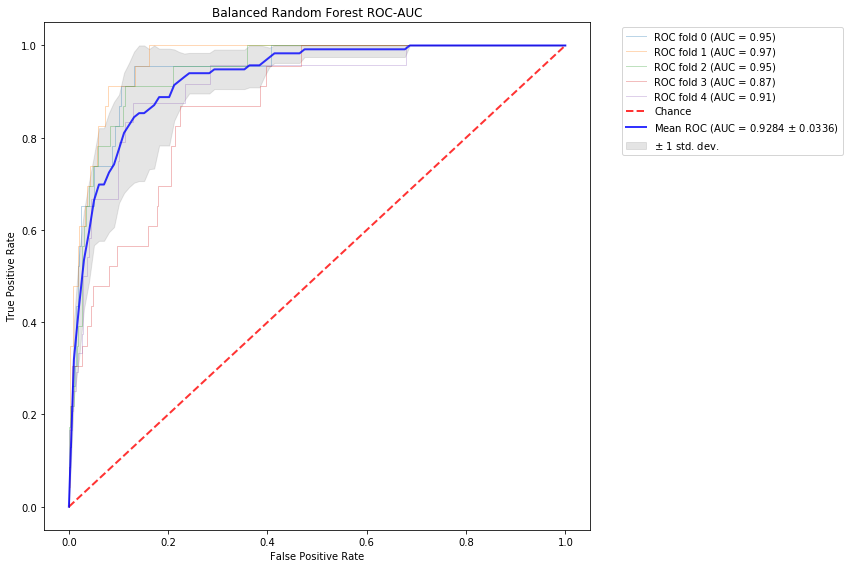

Parameters used:
 {'max_depth': 7.0, 'n_estimators': 500, 'sampling_strategy': 0.125}


In [4]:
brf_pkl = PKL_PATH + 'gs_rocauc_brf_all.pkl'
brf_gs_res = pd.read_pickle(brf_pkl)

params = brf_gs_res.drop('roc_auc',axis=1).iloc[0].to_dict()
params['n_estimators'] = int(params['n_estimators'])

my_brf = BalancedRandomForestClassifier()
my_std = preprocessing.StandardScaler()

pipe = pipeline.Pipeline([('std',my_std), ('clf',my_brf)])
pipe['clf'].set_params(**params)

brf_res = roc_plt(X, y, pipe, "Balanced Random Forest ROC-AUC", seed=seed, create_plot=True)
print(f"Parameters used:\n {params}")

### Neural Network

In [6]:
from tensorflow import keras
import tensorflow as tf

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(nr_features, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
          16, activation='relu', input_shape=(nr_features,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(
          16, activation='relu', input_shape=(nr_features,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy())

    return model

In [ ]:
# nn grid search for roc-auc curve all variables
X, y = data['muchlinski']
scoring='roc_auc'
nn_pkl = PKL_PATH + 'gs_rocauc_nn_all.pkl'

neg, pos = np.bincount(y)
total = neg + pos

weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

initial_bias = np.log([pos/neg])

def build_fn():
    return make_model(X.shape[-1], initial_bias)

k_folds = 5
batch_size = [10, 512, 1024, 2048]
epochs = [10, 50, 100]
class_weights = {0: weight_for_0, 1: weight_for_1}
print(class_weights)

parameters = {'clf__batch_size' : batch_size,
              'clf__epochs' :  epochs }

param_grid = [parameters]

my_nn = keras.wrappers.scikit_learn.KerasClassifier(build_fn)
my_std = preprocessing.StandardScaler()

pipe = pipeline.Pipeline([('std',my_std), ('clf',my_nn)])

perform_gridsearch_cv(X, y, param_grid, pipe, k_folds, scoring, nn_pkl, parallel_jobs, class_weights)

In [7]:
nn_pkl = PKL_PATH + 'gs_rocauc_nn_all.pkl'
nn_gs_res = pd.read_pickle(nn_pkl)

params = nn_gs_res.drop('roc_auc',axis=1).iloc[0].to_dict()
print(params)

my_nn = keras.wrappers.scikit_learn.KerasClassifier(build_fn)
my_nn._estimator_type = "classifier"
my_std = preprocessing.StandardScaler()

pipe = pipeline.Pipeline([('std',my_std), ('clf',my_nn)])
pipe['clf'].set_params(**params)

nn_res = roc_plt(X, y, pipe, "Neural Network ROC-AUC", seed=seed, create_plot=True)
print(f"Parameters used:\n {params}")

ValueError: unsupported pickle protocol: 5

### Aggregating the Roc-Auc results from each classifier

In [2]:
# load grid search result
svm_pkl = PKL_PATH + 'gs_rocauc_svm_all.pkl'
svm_gs_res = pd.read_pickle(svm_pkl)

X, y = data['muchlinski']

# retrieve best parameters
params = svm_gs_res.drop('roc_auc',axis=1).iloc[0]
params['degree'] = 1 if np.isnan(params['degree']) else params['degree']

my_svm = svm.SVC(random_state=seed)
my_std = preprocessing.StandardScaler()

# set best parameters
pipe = pipeline.Pipeline([('std',my_std), ('clf',my_svm)])
pipe['clf'].set_params(**params.to_dict())

# plot resulting roc plot
svm_res = roc_plt(X, y, pipe, "Support Vector Machine ROC-AUC", seed=seed, create_plot=False)
print(f"Parameters used:\n {params}")

Parameters used:
 C                      0.001
class_weight    {0: 1, 1: 8}
kernel                   rbf
degree                     1
Name: 10, dtype: object


In [3]:
# load grid search result
bdt_pkl = PKL_PATH + 'gs_rocauc_bdt_all.pkl'
bdt_gs_res = pd.read_pickle(bdt_pkl)

X, y = data['muchlinski']

# retrieve best parameters
params = bdt_gs_res.drop('roc_auc',axis=1).iloc[0].to_dict()
params['n_estimators'] = int(params['n_estimators'])

my_bdt = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(), random_state=0)
my_std = preprocessing.StandardScaler()

# set best parameters
pipe = pipeline.Pipeline([('std',my_std), ('clf',my_bdt)])
pipe['clf'].set_params(**params)

# plot resulting roc plot
bdt_res = roc_plt(X, y, pipe, "Boosted Decision Tree ROC-AUC", seed=seed, create_plot=False)
print(f"Parameters used:\n {params}")

Parameters used:
 {'base_estimator__max_depth': 8.0, 'learning_rate': 1.0, 'n_estimators': 140}


In [4]:
# load grid search result
knn_pkl = PKL_PATH + 'gs_rocauc_knn_all.pkl'
knn_gs_res = pd.read_pickle(PKL_PATH+'gs_rocauc_knn_all.pkl')

X, y = data['muchlinski']

# retrieve best parameters
params = knn_gs_res.drop('roc_auc',axis=1).iloc[0]

my_knn = neighbors.KNeighborsClassifier()
my_std = preprocessing.StandardScaler()

# set best parameters
pipe = pipeline.Pipeline([('std',my_std), ('clf',my_knn)])
pipe['clf'].set_params(**params.to_dict())

# plot resulting roc plot
knn_res = roc_plt(X, y, pipe, "KNN ROC-AUC", seed=seed, create_plot=False)
print(f"Parameters used:\n {params}")

Parameters used:
 n_neighbors           9
p                     1
weights        distance
Name: 57, dtype: object


In [5]:
brf_pkl = PKL_PATH + 'gs_rocauc_brf_all.pkl'
brf_gs_res = pd.read_pickle(brf_pkl)

params = brf_gs_res.drop('roc_auc',axis=1).iloc[0].to_dict()
params['n_estimators'] = int(params['n_estimators'])

my_brf = BalancedRandomForestClassifier()
my_std = preprocessing.StandardScaler()

pipe = pipeline.Pipeline([('std',my_std), ('clf',my_brf)])
pipe['clf'].set_params(**params)

brf_res = roc_plt(X, y, pipe, "Balanced Random Forest ROC-AUC", seed=seed, create_plot=False)
print(f"Parameters used:\n {params}")

Parameters used:
 {'max_depth': 7.0, 'n_estimators': 500, 'sampling_strategy': 0.125}


In [6]:
svm_res = pd.DataFrame(svm_res)
svm_res['clf'] = 'Support Vector Machine'
bdt_res = pd.DataFrame(bdt_res)
bdt_res['clf'] = 'Boosted Decision Trees'
knn_res = pd.DataFrame(knn_res)
knn_res['clf'] = 'K-Nearest Neighbors'
brf_res = pd.DataFrame(brf_res)
brf_res['clf'] = 'Balanced Random Forest'

rocauc_res = pd.concat([svm_res, bdt_res, knn_res, brf_res])
rocauc_res['Classifier'] = rocauc_res['clf'] + ' : Auc Score: ' + rocauc_res['mean_auc'].round(4).astype(str)
rocauc_res = rocauc_res.sort_values('mean_auc', ascending=False)

model_names = ['Boosted Decision Trees','Support Vector Machine','Balanced Random Forest','K-Nearest Neighbors','Neural Network']
colors = dict(zip(model_names, sns.color_palette("colorblind",5))) 
colors = {k: colors[k] for k in rocauc_res['clf'].unique().tolist()}

In [13]:
def aggregated_roc_plot(df, colors, title, save_path=None, k_folds=5):
    fig, axs = plt.subplots(figsize=(11,8))
    g = sns.lineplot(x='mean_fpr', y='mean_tpr', data=df, hue='Classifier', palette=colors, lw=3)
    g.set_xlabel(f'Mean False Positive Rate over {k_folds} CV test folds')
    g.set_ylabel(f'Mean True Positive Rate over {k_folds} CV test folds')
    g.set_title(title)
    plt.show()
    
    if save_path!=None:
        g.figure.savefig(save_path)

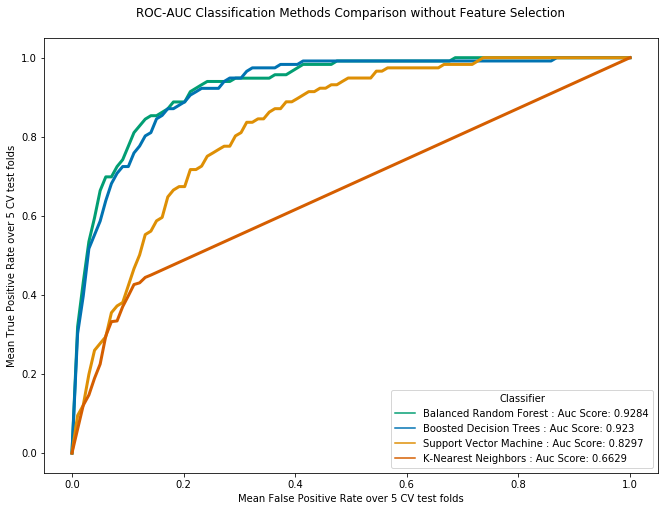

In [14]:
aggregated_roc_plot(rocauc_res, list(colors.values()), 'ROC-AUC Classification Methods Comparison without Feature Selection\n', IMG_PATH+'roc_no_fs.pdf')